In [1]:
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from unidecode import unidecode
import time
from dateutil import parser

from scipy.stats import poisson
from scipy.stats import norm


import aiohttp
import asyncio
import csv
import itertools
import os
from datetime import datetime, timedelta, date

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

pd.set_option('display.max_columns', None)

# Fixture Generation Functions

In [2]:
def ordinal(n):
    n = int(n)
    if 10 <= n % 100 < 20:
        return str(n) + 'th'
    else:
        return  str(n) + {1 : 'st', 2 : 'nd', 3 : 'rd'}.get(n % 10, "th")

def generate_fixtures(custom_fixtures = None, exclude_past_games = True, last_date = None):
    team_data_df = pd.read_csv('../data/team_data.csv')
    # team_data_df['gd'] = team_data_df['g_for'] - team_data_df['g_against']
    # team_data_df = team_data_df.sort_values(by='gd', ascending=False)
    team_data_dict = team_data_df.set_index('fotmob_team').T.to_dict()
    pl_team_list = team_data_dict.keys()

    competition_dict = {'pl': {'id': '47', 'ccode3': 'GBR',},
                        'fa_cup': {'id': '132', 'ccode3': 'GBR',},
                        'league_cup': {'id': '133', 'ccode3': 'GBR',},
                        'ucl': {'id': '42', 'ccode3': 'GBR',},
                        'europa_league': {'id': '73', 'ccode3': 'GBR',},
                        'europa_conference_league': {'id': '10216', 'ccode3': 'GBR',},
                        }

    match_name_list = []
    fixture_df = pd.DataFrame(columns=('comp', 'home_team', 'away_team', 'short_home_team', 'short_away_team', 'datetime_str', 'date_str', 'datetime_obj'))

    fantasy_format = 'TFF'

    if fantasy_format == 'FPL':
        competition_subset_dict = {k:v for k, v in competition_dict.items() if k == 'pl'}
        period_separation = 'fpl_gw'
    elif fantasy_format == 'TFF':
        # need to add other formats
        competition_subset_dict = {k:v for k, v in competition_dict.items() if k == 'pl'}
        period_separation = 'datetime_str'

    # fpl_gw_starts = pd.read_csv('../data/fpl_gw_starts.csv')

    for key, params in competition_subset_dict.items():
        response = requests.get('https://www.fotmob.com/api/leagues', params=params)
        data = response.json()
        match_dict_list = data['matches']['allMatches']
        if key == 'pl':
            for match in match_dict_list:
                fotmob_home_team = match['home']['shortName']
                fotmob_away_team = match['away']['shortName']
                datetime_str = match['status']['utcTime']
                date_str = match['status']['utcTime'].split("T")[0]
                datetime_obj = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
                fpl_gw = match['roundName']

                short_home_team = team_data_dict[fotmob_home_team]['short_team']
                short_away_team = team_data_dict[fotmob_away_team]['short_team']
                fixture_df.loc[len(fixture_df)] = [key, fotmob_home_team, fotmob_away_team, short_home_team, short_away_team, datetime_str, date_str, datetime_obj]
    fixture_df['probability'] = 1

    # add custom fixtures
    if custom_fixtures is not None:
        for index, row in custom_fixtures.iterrows():
            comp = row['comp']
            short_home_team = row['home_team']
            short_away_team = row['away_team']
            fixture_df = fixture_df.drop(fixture_df[(fixture_df['comp'] == comp) & (fixture_df['short_home_team'] == short_home_team) & (fixture_df['short_away_team'] == short_away_team)].index).reset_index(drop=True)

            for datetime_str, probability in row['datetime_probs'].items():
                # parser.parse(x)
                datetime_obj = parser.parse(datetime_str)
                date_str = datetime.strftime(datetime_obj, "%Y-%m-%d")
                datetime_str = datetime.strftime(datetime_obj, '%Y-%m-%dT%H:%M:%SZ')
                datetime_obj = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
                fotmob_home_team = team_data_df.loc[team_data_df['short_team'] == short_home_team, 'fotmob_team'].values[0]
                fotmob_away_team = team_data_df.loc[team_data_df['short_team'] == short_away_team, 'fotmob_team'].values[0]
                fixture_df.loc[len(fixture_df)] = [comp, fotmob_home_team, fotmob_away_team, short_home_team, short_away_team, datetime_str, date_str, datetime_obj, probability]


    fixture_df = fixture_df.sort_values(by='datetime_obj', ascending=True)

    # remove matches outside time bounds
    if exclude_past_games:
        today_datetime = datetime.today()
        for index, row in fixture_df.copy().iterrows():
            if row['datetime_str'] < today_datetime:
                fixture_df = fixture_df.loc[fixture_df['datetime_str']!=row['datetime_str']]
        fixture_df.reset_index(drop=True)
    if last_date is not None:
        last_date_str = datetime.strftime(parser.parse(last_date), "%Y-%m-%d")
        for index, row in fixture_df.copy().iterrows():
            if row['datetime_str'] > last_date_str:
                fixture_df = fixture_df.loc[fixture_df['datetime_str']!=row['datetime_str']]
        fixture_df.reset_index(drop=True)

    gw_ref = pd.read_csv('../data/gw_ref.csv')
    fixture_df = pd.merge(left=fixture_df, right=gw_ref, on='date_str')

    num_unique_datetime = len(fixture_df[period_separation].unique())
    fixture_ticker = pd.DataFrame(columns=['team'] + ['short_team'] +list(fixture_df[period_separation].unique()))

    for team in pl_team_list:
        fixture_ticker.loc[len(fixture_ticker)] = [team] + [team_data_df.loc[team_data_df['fotmob_team']==team,'short_team'].values[0]] + [''] * num_unique_datetime

    for index, row in fixture_df.iterrows():
        prob_str = ''
        if row['probability'] != 1:
            prob_str = '*' + str(round(row['probability'],2))[1:]
        if row['home_team'] in pl_team_list:
            fixture_ticker.loc[fixture_ticker['team'] == row['home_team'], [row[period_separation]]] += '\n'+row['short_away_team'] + prob_str
        if row['away_team'] in pl_team_list:
            fixture_ticker.loc[fixture_ticker['team'] == row['away_team'], [row[period_separation]]] += '\n'+row['short_home_team'].lower() + prob_str


    # make formatted dataframe
    f_fixture_ticker = fixture_ticker.copy()
    datetime_str_cols = [x for i, x in enumerate(f_fixture_ticker.columns.tolist()) if len(x)>10]
    numeric_header =  [str(i-1) if 'team' not in x else x for i, x in enumerate(f_fixture_ticker.columns.tolist())]
    time_header = ['',''] + [parser.parse(x).strftime("%H:%M") for x in datetime_str_cols]
    daynum_header = ['',''] + [ordinal(parser.parse(x).strftime("%d")) for x in datetime_str_cols]
    weekday_header = ['',''] + [parser.parse(x).strftime("%a") for x in datetime_str_cols]
    gw_ref = pd.read_csv('../data/gw_ref.csv')
    tff_gw_header = ['',''] + ['GW' + str(gw_ref.loc[gw_ref['date_str']== x.split('T')[0], 'tff_gw'].values[0]) for x in datetime_str_cols]
    month_header = ['',''] + [parser.parse(x).strftime("%b") for x in datetime_str_cols]
    f_fixture_ticker.columns = [month_header, tff_gw_header, weekday_header, daynum_header, time_header, numeric_header]
    # Make color map dictionary and function
    team_data_df['h_gd'] = team_data_df['g_for']*team_data_df['home_adv'] - team_data_df['g_against']/team_data_df['home_adv']
    team_data_df['a_gd'] = team_data_df['g_for']/team_data_df['home_adv'] - team_data_df['g_against']*team_data_df['home_adv']
    color_ts = team_data_df[['short_team','h_gd', 'a_gd']].copy()
    min_gd = min(color_ts['h_gd'].values.tolist() + color_ts['a_gd'].values.tolist())*2.3
    max_gd = max(color_ts['h_gd'].values.tolist() + color_ts['a_gd'].values.tolist())#*1.8
    norm = matplotlib.colors.Normalize(vmin=min_gd, vmax=max_gd, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis_r)
    color_ts['h_gd_color'] = color_ts['h_gd'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    color_ts['a_gd_color'] = color_ts['a_gd'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    h_teams = color_ts['short_team'].values.tolist()
    a_teams = [team.lower() for team in h_teams]
    teams = h_teams + a_teams
    team_gd = color_ts['a_gd_color'].values.tolist() + color_ts['h_gd_color'].values.tolist()
    color_dict = {teams[i]: team_gd[i] for i in range(len(teams))}
    def color_col(col, pattern_map, default=''):
        return np.select(
            [col.str.contains(k, na=False) for k in pattern_map.keys()],
            [f'background-color: {v}' for v in pattern_map.values()],
            default=default
        ).astype(str)
    # Apply styles
    f_fixture_ticker = f_fixture_ticker.style.apply(color_col,
                                                pattern_map=color_dict
                                                , subset=f_fixture_ticker.columns[2:]
                                                )
    f_fixture_ticker = f_fixture_ticker.set_table_styles([
                        {'selector': 'th.col_heading', 'props': 'text-align: left;'},
                        {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
                        {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
                    ], overwrite=False)
    f_fixture_ticker = f_fixture_ticker.set_properties(**{'color': 'white'},subset=(f_fixture_ticker.columns[2:]))

    # formatted_fixtures.columns = [formatted_fixtures.columns , [i for i, x in enumerate(formatted_fixtures.columns) ]]

    return {'f_fixture_ticker': f_fixture_ticker, 'unf_fixture_ticker': fixture_ticker, 'fixture_df': fixture_df}

In [3]:
# custom_fixtures = pd.DataFrame(columns=('comp', 'home_team', 'away_team', 'datetime_probs'))
# custom_fixtures.loc[len(custom_fixtures)] = ['pl', 'MUN', 'FUL', {'2024-08-16T19:00:00Z':0.5, '2024-08-17T11:30:00Z':0.5}]
# custom_fixtures.loc[len(custom_fixtures)] = ['pl', 'MUN', 'LIV', {'2024-08-16':0.5, '2024-08-17T12:30:00Z':0.5}]
fixtures = generate_fixtures(custom_fixtures=None, exclude_past_games=False, last_date='2024-10-05')
fixtures['f_fixture_ticker']

In [115]:
fixture_df = fixtures['fixture_df']
fixture_df.head()

,comp,home_team,away_team,short_home_team,short_away_team,datetime_str,date_str,datetime_obj,probability,fpl_gw,tff_gw
0,pl,Man United,Fulham,MUN,FUL,2024-08-16T19:00:00Z,2024-08-16,2024-08-16 19:00:00,1,1,1
1,pl,Ipswich,Liverpool,IPS,LIV,2024-08-17T11:30:00Z,2024-08-17,2024-08-17 11:30:00,1,1,1
2,pl,Arsenal,Wolves,ARS,WOL,2024-08-17T14:00:00Z,2024-08-17,2024-08-17 14:00:00,1,1,1
3,pl,Everton,Brighton,EVE,BHA,2024-08-17T14:00:00Z,2024-08-17,2024-08-17 14:00:00,1,1,1
4,pl,Newcastle,Southampton,NEW,SOU,2024-08-17T14:00:00Z,2024-08-17,2024-08-17 14:00:00,1,1,1


# Modelling Functions

In [66]:
def player_data_gen(fixture_df):
    player_data = pd.read_csv('../data/player_data.csv')

    all_gw_list = sorted(fixture_df['fpl_gw'].unique())
    
    try:
        filepath = '../data/fplreview.csv'
        fplreview = pd.read_csv(filepath)
        fplreview = fplreview.rename(columns={'ID': 'fpl_id'})
        review_xmins = True
        print(f"Using minutes from {filepath}")
    except:
        review_xmins = False
        print(f"{filepath} not found, using default baseline minutes") 

    if review_xmins:
        review_gw_list = []
        for element in list(fplreview.columns.values):
            if '_xMins' in element:
                review_gw_list.append(int(element.split('_')[0]))
        review_gw_list.sort()
        for gw in all_gw_list:
            if gw < review_gw_list[0]:
                fplreview[f'{gw}_xMins'] = fplreview[f'{review_gw_list[0]}_xMins']
            elif gw > review_gw_list[-1]:
                fplreview[f'{gw}_xMins'] = int(fplreview[f'{review_gw_list[-1]}_xMins'] * (0.98**(gw - review_gw_list[-1])))
        player_data = pd.merge(player_data, fplreview.loc[:,['fpl_id'] + [f'{x}_xMins' for x in all_gw_list]], on=['fpl_id'], how='inner')

    else:
        for gw in all_gw_list:
            player_data[str(gw)+'_xMins'] = player_data['bl_xmin']
    return player_data


def eg_to_cs(eg=1.61):
    return poisson.cdf(k=0, mu=eg)


def pen_takers_from_fix(player_data, short_team = 'NEW', fpl_gw = 1, n_pens = 0.2):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data['on_pens']>0) & (player_data[f'{fpl_gw}_xMins']>0)]
    pen_taker_dict = {player_row['tff_id']: (player_row[f'{fpl_gw}_xMins']**2.5)*(player_row['on_pens']**0.8)/95 for player_index, player_row in player_data_subset.iterrows()}
    value_sum = sum(pen_taker_dict.values())
    pen_taker_dict = {key: round(value*n_pens/value_sum, 3) for key, value in pen_taker_dict.items()}
    return pen_taker_dict

def np_scorers_from_fix(player_data, short_team = 'NEW', fpl_gw = 1, team_npg = 1.5):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data['bl_npxg']>0.01) & (player_data[f'{fpl_gw}_xMins']>0)]
    npg_dict = {player_row['tff_id']: player_row[f'{fpl_gw}_xMins']*player_row['bl_npxg']*player_row['fin_skill']/95 for player_index, player_row in player_data_subset.iterrows()}
    npg_sum = sum(npg_dict.values())
    npg_dict = {key: round(value*team_npg/npg_sum, 3) for key, value in npg_dict.items()}
    return npg_dict

def assisters_from_fix(player_data, short_team = 'NEW', fpl_gw = 1, team_ag = 1.5):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data['bl_a']>0.01) & (player_data[f'{fpl_gw}_xMins']>0)]
    a_dict = {player_row['tff_id']: player_row[f'{fpl_gw}_xMins']*player_row['bl_a']/95 for player_index, player_row in player_data_subset.iterrows()}
    a_sum = sum(a_dict.values())
    a_dict = {key: round(value*team_ag/a_sum, 3) for key, value in a_dict.items()}
    return a_dict

def list_players_in_team(player_data, short_team = 'NEW', fpl_gw = 1, xmin_cutoff=10):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data[f'{fpl_gw}_xMins']>xmin_cutoff)]
    player_list = player_data_subset['tff_id'].to_list()
    return player_list


def add_team_lvl_projections(player_data, fixture_df, spreadex_weight=None, xmin_cutoff=0):

    team_data_df = pd.read_csv('../data/team_data.csv')

    if spreadex_weight is not None:
        pass

    fixture_df['home_g'] = 1.1
    fixture_df['home_cs'] = 0.5
    fixture_df['away_g'] = 1.1
    fixture_df['away_cs'] = 0.5

    fixture_df['home_pen_takers'] = pd.Series(dtype='object')
    fixture_df['away_pen_takers'] = pd.Series(dtype='object')

    fixture_df['home_np_scorers'] = pd.Series(dtype='object')
    fixture_df['away_np_scorers'] = pd.Series(dtype='object')

    # fixture_df['home_scorers'] = pd.Series(dtype='object')
    # fixture_df['away_scorers'] = pd.Series(dtype='object')

    fixture_df['home_assisters'] = pd.Series(dtype='object')
    fixture_df['away_assisters'] = pd.Series(dtype='object')

    fixture_df['home_players'] = pd.Series(dtype='object')
    fixture_df['away_players'] = pd.Series(dtype='object')

    for match_index, match_row in fixture_df.iterrows():
        home_g = team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'g_for'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'g_against_k'].values[0]
        away_g = team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'g_for'].values[0] / team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'g_against_k'].values[0]

        fixture_df.at[match_index, 'home_g'] = home_g
        fixture_df.at[match_index, 'away_g'] = away_g
        fixture_df.at[match_index, 'home_cs'] = eg_to_cs(away_g)
        fixture_df.at[match_index, 'away_cs'] = eg_to_cs(home_g)

        n_home_pens = team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'pk_att_for'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'pk_att_against_k'].values[0]
        n_away_pens = team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'pk_att_for'].values[0] / team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'pk_att_against_k'].values[0]

        h_p_dict = pen_takers_from_fix(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, n_pens = n_home_pens) 
        fixture_df.at[match_index, 'home_pen_takers'] = h_p_dict
        a_p_dict = pen_takers_from_fix(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, n_pens = n_away_pens)
        fixture_df.at[match_index, 'away_pen_takers'] = a_p_dict

        # team goals adjusted for penalties, and the number of own goals per goal
        h_npg_dict = np_scorers_from_fix(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_npg = (home_g-(n_home_pens*0.79))*0.965)
        fixture_df.at[match_index, 'home_np_scorers'] = h_npg_dict
        a_npg_dict = np_scorers_from_fix(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_npg = (away_g-(n_away_pens*0.79))*0.965)
        fixture_df.at[match_index, 'away_np_scorers'] = a_npg_dict

        # h_g_dict = {k: round(h_p_dict.get(k, 0) + h_npg_dict.get(k, 0),3) for k in set(h_p_dict) | set(h_npg_dict)}
        # fixture_df.at[match_index, 'home_scorers'] = h_g_dict
        # a_g_dict = {k: round(a_p_dict.get(k, 0) + a_npg_dict.get(k, 0),3) for k in set(a_p_dict) | set(a_npg_dict)}
        # fixture_df.at[match_index, 'away_scorers'] = a_g_dict

        # team goals adjusted for number of goals assisted in telegraph in 23/24 (0.90045...)
        fixture_df.at[match_index, 'home_assisters'] = assisters_from_fix(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_ag = home_g*0.9005)
        fixture_df.at[match_index, 'away_assisters'] = assisters_from_fix(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_ag = away_g*0.9005)

        fixture_df.at[match_index, 'home_players'] = list_players_in_team(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, xmin_cutoff = xmin_cutoff)
        fixture_df.at[match_index, 'away_players'] = list_players_in_team(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, xmin_cutoff = xmin_cutoff)

    fixture_df = fixture_df.round(2)
    return fixture_df


def tff_ev_calc(player_dict, opp_dict, team_dict, fpl_gw=1, e_npg=0.3, e_pen=0.01, e_assists=0.3, cs=0.2, ga=1.5, odds_goals=None, odds_assists=None):

    xmin = player_dict[f'{fpl_gw}_xMins']
    x_95s = xmin/95
    p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
    p_sub = (1-p_start) * x_95s

    ev = 0
    ev += 2 * p_start
    ev += 1 * p_sub
    ev += 5 * e_npg
    ev += 5 * e_pen * player_dict['fin_skill'] * 0.79
    ev -= 2 * e_pen / player_dict['fin_skill'] * 0.21
    ev += 3 * e_assists

    if player_dict['tff_position'] < 2.5:
        ev += 5 * cs * p_start * player_dict['pos_bl_p_60_given_start']
        # approximation of poisson cdf sum, coeffs: array([-0.01146325,  0.0888773 ,  0.34962138, -0.06239911,  0.0041391 ])
        mu_gc = ga * x_95s
        ev -= (0.0041391*(mu_gc**4) - 0.06239911*(mu_gc**3) + 0.34962138*(mu_gc**2) + 0.0888773*mu_gc - 0.01146325)
        if player_dict['tff_position'] == 1:
            # approximation of poisson cdf sum, coeffs: array([-0.05142347,  0.28689925,  0.07500592, -0.01004676,  0.00034356])
            mu_sv = player_dict['bl_sv_per_sot'] * opp_dict['sot_for'] * team_dict['sot_against_k'] * x_95s
            ev += max(0.00034356*(mu_sv**4) - 0.01004676*(mu_sv**3) + 0.07500592*(mu_sv**2) + 0.28689925*mu_sv - 0.05142347, 0)
            # pen_saves
            ev += 5 * opp_dict['pk_att_for'] * team_dict['pk_att_against_k'] * 0.11 * x_95s

    if player_dict['tff_position'] == 3:
        # approximation of poisson cdf sum
        mu_tackle = player_dict['bl_tackle'] * opp_dict['tackle_against_k'] * x_95s
        ev += max(0.00034356*(mu_tackle**4) - 0.01004676*(mu_tackle**3) + 0.07500592*(mu_tackle**2) + 0.28689925*mu_tackle - 0.05142347, 0)

    # yellows, reds, OGs
    ev -= 1 * player_dict['bl_yc'] * opp_dict['yc_against_k'] * x_95s
    ev -= 3 * player_dict['bl_rc'] * opp_dict['rc_against_k'] * x_95s
    ev -= 3 * player_dict['bl_og'] * opp_dict['og_against_k'] * x_95s

    return ev


def generate_ev(custom_fixtures=None, exclude_past_games=True, last_date=None, xmin_cutoff=0):
    fixture_results_r = generate_fixtures(custom_fixtures=custom_fixtures, exclude_past_games=exclude_past_games, last_date=last_date)

    player_data = player_data_gen(fixture_df = fixture_results_r['fixture_df'])
    team_data = pd.read_csv('../data/team_data.csv')

    fixture_df = add_team_lvl_projections(player_data = player_data, fixture_df = fixture_results_r['fixture_df'], spreadex_weight = None)

    fixture_times = list(fixture_df['datetime_str'].unique())

    # initialize player EV dataframe
    pos_dict = {1: 'G', 2: 'D', 3: 'M', 4: 'F'}
    columns = ['tff_id', 'team', 'player', 'tff_pos', 'tff_cost'] + fixture_times + ['total_pts', 'ppm']
    ev_df = pd.DataFrame(columns = columns)
    for index, row in player_data.iterrows():
        ev_df.loc[len(ev_df)] = [int(row['tff_id']), row['short_team'], row['fpl_web_player'], pos_dict[row['tff_position']], row['tff_cost']] + [0] * (len(fixture_times)+2)

    # populate ev table
    for match_index, match_row in fixture_df.iterrows():
        datetime_str = match_row['datetime_str']
        fpl_gw = match_row['fpl_gw']
        for player_id in match_row['home_players']:
            player_dict = player_data.loc[player_data['tff_id']==player_id].to_dict('records')[0]
            team_dict = team_data.loc[team_data['short_team']==match_row['short_home_team']].to_dict('records')[0]
            opp_dict = team_data.loc[team_data['short_team']==match_row['short_away_team']].to_dict('records')[0]
            e_npg = match_row['home_np_scorers'].get(player_id, 0)
            e_pen = match_row['home_pen_takers'].get(player_id, 0)
            e_assists = match_row['home_assisters'].get(player_id, 0)
            cs = match_row['home_cs']
            ga = match_row['away_g']
            ev = tff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, cs=cs, ga=ga)
            ev_df.loc[ev_df['tff_id'] == player_id, datetime_str] += ev
        for player_id in match_row['away_players']:
            player_dict = player_data.loc[player_data['tff_id']==player_id].to_dict('records')[0]
            team_dict = team_data.loc[team_data['short_team']==match_row['short_away_team']].to_dict('records')[0]
            opp_dict = team_data.loc[team_data['short_team']==match_row['short_home_team']].to_dict('records')[0]
            e_npg = match_row['away_np_scorers'].get(player_id, 0)
            e_pen = match_row['away_pen_takers'].get(player_id, 0)
            e_assists = match_row['away_assisters'].get(player_id, 0)
            cs = match_row['away_cs']
            ga = match_row['home_g']
            ev = tff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, cs=cs, ga=ga)
            ev_df.loc[ev_df['tff_id'] == player_id, datetime_str] += ev

    ev_df['total_pts'] = ev_df.loc[:, fixture_times].sum(axis=1)
    ev_df['ppm'] = ev_df['total_pts'] / ev_df['tff_cost']
    ev_df = ev_df.sort_values(by='total_pts', ascending=False).reset_index(drop=True)
    for column in ev_df.columns:
        if column in fixture_times:
            ev_df[column] = ev_df[column].astype('float64')
    ev_df = ev_df.round(2)

    ev_df.to_csv('../data/tff_model_output.csv', index=False)

    return ev_df

In [69]:
ev_df = generate_ev(custom_fixtures=None, exclude_past_games=False, last_date='2024-10-05', xmin_cutoff=50)

Using minutes from ../data/fplreview.csv


# Trash

<AxesSubplot:xlabel='tff_cost', ylabel='total_pts'>

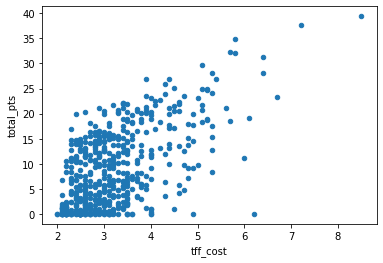

In [70]:
ev_df.plot.scatter(x = 'tff_cost', y = 'total_pts')

<Figure size 2400x1920 with 0 Axes>

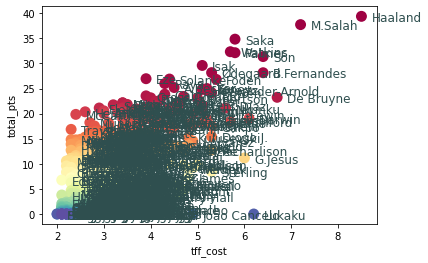

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string

from matplotlib.pyplot import figure

figure(figsize=(30, 24), dpi=80)


from matplotlib import cm

fig, ax = plt.subplots()

ev_df.plot('tff_cost', 'total_pts', kind='scatter', ax=ax)

# for k, v in ev_df.iterrows():
#     ax.annotate(v['player'], (v['tff_cost'], v['total_pts']))

cmap = cm.get_cmap('Spectral')
ev_df.plot('tff_cost', 'total_pts', kind='scatter', ax=ax, s=120, linewidth=0, 
        c=range(len(ev_df)), colormap=cmap)

for k, v in ev_df.iterrows():
    ax.annotate(v['player'], (v['tff_cost'], v['total_pts']),
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12, color='darkslategrey')

In [7]:
from scipy.optimize import curve_fit

<AxesSubplot:xlabel='mu_tackles', ylabel='fit'>

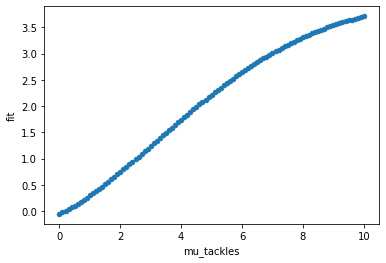

In [57]:
mu_tackles = 0
tackle_df = pd.DataFrame(columns=['mu_tackles', 'points'])
while mu_tackles < 10:
    points = (1-poisson.cdf(k=1, mu=mu_tackles)) + (1-poisson.cdf(k=3, mu=mu_tackles)) + (1-poisson.cdf(k=5, mu=mu_tackles)) + (1-poisson.cdf(k=7, mu=mu_tackles)) 
    + (1-poisson.cdf(k=9, mu=mu_tackles)) + (1-poisson.cdf(k=11, mu=mu_tackles)) + (1-poisson.cdf(k=13, mu=mu_tackles)) + (1-poisson.cdf(k=15, mu=mu_tackles)) 
    + (1-poisson.cdf(k=17, mu=mu_tackles)) + (1-poisson.cdf(k=19, mu=mu_tackles)) + (1-poisson.cdf(k=21, mu=mu_tackles)) + (1-poisson.cdf(k=23, mu=mu_tackles)) 
    # points = 2*(poisson.cdf(k=4, mu=mu_tackles) - poisson.cdf(k=3, mu=mu_tackles)) + 3*(1 - poisson.cdf(k=4, mu=mu_tackles))
    tackle_df.loc[len(tackle_df)] = [mu_tackles, points]
    mu_tackles+=0.1

poly = np.polyfit(tackle_df['mu_tackles'], tackle_df['points'], deg=4)

mu_tackles = 0
tackle_df = pd.DataFrame(columns=['mu_tackles', 'points', 'fit'])
while mu_tackles < 10:
    points = (1-poisson.cdf(k=1, mu=mu_tackles)) + (1-poisson.cdf(k=3, mu=mu_tackles)) + (1-poisson.cdf(k=5, mu=mu_tackles)) + (1-poisson.cdf(k=7, mu=mu_tackles)) 
    + (1-poisson.cdf(k=9, mu=mu_tackles)) + (1-poisson.cdf(k=11, mu=mu_tackles)) + (1-poisson.cdf(k=13, mu=mu_tackles)) + (1-poisson.cdf(k=15, mu=mu_tackles)) 
    + (1-poisson.cdf(k=17, mu=mu_tackles)) + (1-poisson.cdf(k=19, mu=mu_tackles)) + (1-poisson.cdf(k=21, mu=mu_tackles)) + (1-poisson.cdf(k=23, mu=mu_tackles)) 
    # points = 2*(poisson.cdf(k=4, mu=mu_tackles) - poisson.cdf(k=3, mu=mu_tackles)) + 3*(1 - poisson.cdf(k=4, mu=mu_tackles))
    tackle_df.loc[len(tackle_df)] = [mu_tackles, points, np.polyval(poly, mu_tackles)]
    mu_tackles+=0.1

tackle_df.plot.scatter(x = 'mu_tackles', y = 'fit')

<AxesSubplot:xlabel='mu_tackles', ylabel='points'>

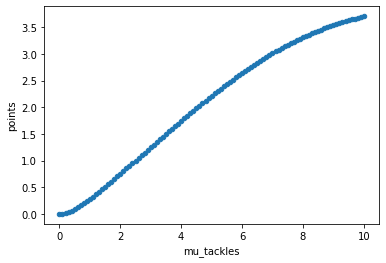

In [58]:
tackle_df.plot.scatter(x = 'mu_tackles', y = 'points')

In [59]:
# poly = np.polyfit(tackle_df['mu_tackles'], tackle_df['points'], deg=5)
# np.polyval(poly, 0)
coefs = np.polynomial.polynomial.polyfit(tackle_df['mu_tackles'], tackle_df['points'], deg=4)
coefs

array([-0.05142347,  0.28689925,  0.07500592, -0.01004676,  0.00034356])

In [50]:
# poly = np.polyfit(tackle_df['mu_tackles'], tackle_df['points'], deg=5)
# np.polyval(poly, 0)
coefs = np.polynomial.polynomial.polyfit(tackle_df['mu_tackles'], tackle_df['points'], deg=4)
coefs

array([-0.05142347,  0.28689925,  0.07500592, -0.01004676,  0.00034356])

<AxesSubplot:xlabel='mu_gc', ylabel='fit'>

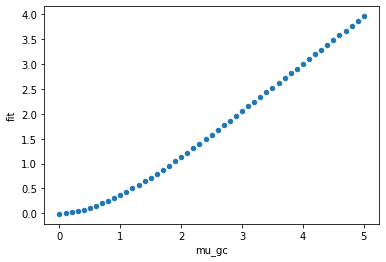

In [29]:
mu_gc = 0
gc_df = pd.DataFrame(columns=['mu_gc', 'points'])
while mu_gc < 5:
    points = (1-poisson.cdf(k=1, mu=mu_gc)) + (1-poisson.cdf(k=2, mu=mu_gc)) + (1-poisson.cdf(k=3, mu=mu_gc)) + (1-poisson.cdf(k=4, mu=mu_gc)) + (1-poisson.cdf(k=5, mu=mu_gc)) + (1-poisson.cdf(k=6, mu=mu_gc)) + (1-poisson.cdf(k=7, mu=mu_gc)) + (1-poisson.cdf(k=8, mu=mu_gc))
    # points = 2*(poisson.cdf(k=4, mu=mu_tackles) - poisson.cdf(k=3, mu=mu_tackles)) + 3*(1 - poisson.cdf(k=4, mu=mu_tackles))
    gc_df.loc[len(gc_df)] = [mu_gc, points]
    mu_gc+=0.1

# gc_df.plot.scatter(x = 'mu_gc', y = '-ve points')

poly = np.polyfit(gc_df['mu_gc'], gc_df['points'], deg=4)

mu_gc = 0
gc_df = pd.DataFrame(columns=['mu_gc', 'points', 'fit'])
while mu_gc < 5:
    points = (1-poisson.cdf(k=1, mu=mu_gc)) + (1-poisson.cdf(k=2, mu=mu_gc)) + (1-poisson.cdf(k=3, mu=mu_gc)) + (1-poisson.cdf(k=4, mu=mu_gc)) + (1-poisson.cdf(k=5, mu=mu_gc)) + (1-poisson.cdf(k=6, mu=mu_gc)) + (1-poisson.cdf(k=7, mu=mu_gc)) + (1-poisson.cdf(k=8, mu=mu_gc))
    # points = 2*(poisson.cdf(k=4, mu=mu_tackles) - poisson.cdf(k=3, mu=mu_tackles)) + 3*(1 - poisson.cdf(k=4, mu=mu_tackles))
    gc_df.loc[len(gc_df)] = [mu_gc, points, np.polyval(poly, mu_gc)]
    mu_gc+=0.1

gc_df.plot.scatter(x = 'mu_gc', y = 'fit')

In [31]:
coefs = np.polynomial.polynomial.polyfit(gc_df['mu_gc'], gc_df['points'], deg=4)
coefs

array([-0.01146325,  0.0888773 ,  0.34962138, -0.06239911,  0.0041391 ])

In [109]:
player_data = player_data_gen()['player_data']
player_data

def pen_takers_from_fix(short_team = 'NEW', fpl_gw = 1, player_data = player_data):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data['on_pens']>0) & (player_data[f'{fpl_gw}_xMins']>0)]

    # pen_taker_dict = {player_row['fpl_web_player']: {'xMins': player_row[f'{fpl_gw}_xMins'], 'base_pen_share': player_row['on_pens']} for player_index, player_row in player_data_subset.iterrows()}

    pen_taker_dict = {player_row['fpl_web_player']: (player_row[f'{fpl_gw}_xMins']**2.5)*(player_row['on_pens']**0.8)/95 for player_index, player_row in player_data_subset.iterrows()}
    value_sum = sum(pen_taker_dict.values())
    pen_taker_dict = {key: round(value/value_sum, 3) for key, value in pen_taker_dict.items()}

    display(player_data_subset)

    return pen_taker_dict

pen_takers_from_fix(short_team = 'AVL', fpl_gw = 1, player_data = player_data)

Using minutes from ../data/fplreview.csv


,fpl_code,fpl_web_player,fpl_full_player,tff_id,fanteam_id,sky_id,fbref_code,fbref_player,spreadex_player,fpl_first_name,fpl_second_name,fpl_web_name,fpl_id,fpl_pos,fpl_now_cost,fpl_team_code,tff_squad_id,tff_first_name,tff_last_name,tff_cost,tff_status,tff_position,tff_locked,tff_nationality,fotmob_team,spreadex_team,fbref_team,short_team,review_short_team,FW,LW,RW,AM,DM,CB,RB,GK,LB,CM,WB,LM,RM,pos_sum,pos_g,pos_npxg,pos_a,pos_sot,pos_pass,pos_tackle,pos_og,pos_yc,pos_rc,pos_p_start_given_mins,pos_p_60_given_start,pos_p_90_given_start,fin_skill,past_g,past_g_weight,past_xg,past_xg_weight,past_npxg,past_npxg_weight,past_a,past_a_weight,past_sot,past_sot_weight,past_pass,past_pass_weight,past_tackle,past_tackle_weight,past_yc,past_yc_weight,noise_factor,sv_per_sot,games_in_min_sample,apps_in_min_sample,sample_xmins,sample_p_start,sample_p_60_given_start,sample_p_90_given_start,bl_g,bl_npxg,bl_a,bl_pass,bl_tackle,bl_sot,bl_yc,bl_rc,bl_og,bl_sv_per_sot,bl_xmin,bl_p_start,bl_p_60_given_start,bl_p_90_given_start,pos_bl_p_60_given_start,pos_bl_p_90_given_start,on_pens,spreadex_ssn_goals,spreadex_ssn_assists,spreadex_gp90,spreadex_ap90,1_xMins,2_xMins,3_xMins,4_xMins,5_xMins,6_xMins,7_xMins,8_xMins,9_xMins,10_xMins,11_xMins,12_xMins
5,178301.0,Watkins,Ollie Watkins,178301.0,183114.0,645.0,aed3a70f,Ollie Watkins,Ollie Watkins,Ollie,Watkins,Watkins,58.0,4.0,9.0,7.0,7.0,Ollie,Watkins,5.7,playing,4.0,False,England,Aston Villa,Aston Villa,Aston Villa,AVL,AVL,1.00,0.00,0.0,0.00,0.00,0.0,0.0,0,0.0,0.00,0.0,0.00,0.00,1.0,0.405000,0.387000,0.151000,1.117240,16.414025,0.337740,0.001130,0.150870,0.003060,0.660000,0.911000,0.471000,1.00,0.508193,1.000000,0.439085,1.000000,0.428960,1.000000,0.186492,1.000000,1.157669,1.000000,14.355986,1.000000,0.186552,1.000000,0.083140,1.000000,1.000000,0.0,38,37,85,0.95,0.95,0.71,0.498717,0.479915,0.202488,14.355986,0.186552,1.157669,0.083140,0.001600,0.000591,0.0,84,0.9310,0.94,0.61,0.911,0.471,0.17,16.750,6.75,0.515702,0.20782,89,88,86,84,84,83,83,83,82,82,82,82
160,122806.0,McGinn,John McGinn,122806.0,131333.0,59.0,90f91999,John McGinn,John McGinn,John,McGinn,McGinn,48.0,3.0,5.5,7.0,7.0,John,McGinn,3.7,playing,3.0,False,Scotland,Aston Villa,Aston Villa,Aston Villa,AVL,AVL,0.12,0.09,0.0,0.03,0.30,0.0,0.0,0,0.0,0.18,0.0,0.26,0.02,1.0,0.159857,0.142761,0.116302,0.518203,37.085808,0.870471,0.001692,0.214829,0.006736,0.709410,0.896679,0.519486,1.02,0.095847,1.000000,0.106795,1.000000,0.106795,1.000000,0.145251,1.000000,0.373544,1.000000,30.649226,1.000000,1.273399,1.000000,0.246779,1.000000,1.000000,0.0,38,35,79,0.92,0.92,0.63,0.170393,0.152956,0.145251,30.649226,1.273399,0.373544,0.246779,0.010456,0.002626,0.0,81,0.9016,0.91,0.63,0.893,0.622,0.13,6.000,NaN,0.186800,NaN,86,85,83,81,80,79,79,78,76,76,76,75
165,166989.0,Tielemans,Youri Tielemans,166989.0,110910.0,335.0,56f7a928,Youri Tielemans,Youri Tielemans,Youri,Tielemans,Tielemans,57.0,3.0,5.5,7.0,7.0,Youri,Tielemans,4.2,playing,3.0,False,Belgium,Aston Villa,Aston Villa,Aston Villa,AVL,AVL,0.11,0.00,0.0,0.02,0.43,0.0,0.0,0,0.0,0.38,0.0,0.02,0.04,1.0,0.126520,0.108289,0.090473,0.407866,41.750322,0.958669,0.001682,0.253597,0.008205,0.743263,0.904448,0.596854,1.05,0.045729,0.571713,0.071252,0.596986,0.052575,0.569427,0.188369,0.462574,0.285868,0.749214,43.934911,0.854774,1.156767,0.886891,0.137033,0.511276,1.428287,0.0,38,32,43,0.42,0.37,0.16,0.164574,0.083003,0.135757,43.617651,1.134360,0.316463,0.194001,0.010013,0.002053,0.0,55,0.4116,0.85,0.39,0.893,0.622,0.70,4.875,NaN,0.168103,NaN,60,57,56,49,46,45,45,45,46,45,44,46


{'Watkins': 0.345, 'McGinn': 0.256, 'Tielemans': 0.399}

In [313]:
spreadex_team_data = pd.read_csv("../data/spreadex_team.csv")
spreadex_team_data = spreadex_team_data.loc[((spreadex_team_data['market_name'] == 'Team Goals (Home)') | (spreadex_team_data['market_name'] == 'Team Goals (Away)'))].reset_index(drop=True)
spreadex_team_data['midpoint'] = (spreadex_team_data['sell'] + spreadex_team_data['buy'])/2
spreadex_team_data = 

,datetime,match_id,home_team,away_team,market_name,selection_name,sell,buy,midpoint
0,2024-07-29T00:23:51.552994,3358011,Man Utd,Fulham,Team Goals (Home),Man Utd Goals,2.30,2.50,2.400
1,2024-07-29T00:23:51.552994,3358011,Man Utd,Fulham,Team Goals (Away),Fulham Goals,1.10,1.25,1.175
2,2024-07-29T00:23:51.552994,3358012,Ipswich,Liverpool,Team Goals (Home),Ipswich Goals,0.90,1.05,0.975
3,2024-07-29T00:23:51.552994,3358012,Ipswich,Liverpool,Team Goals (Away),Liv'pool Goals,2.40,2.60,2.500
4,2024-07-29T00:23:51.552994,3358013,Arsenal,Wolves,Team Goals (Home),Arsenal Goals,2.70,2.90,2.800
5,2024-07-29T00:23:51.552994,3358013,Arsenal,Wolves,Team Goals (Away),Wolves Goals,0.70,0.80,0.750
6,2024-07-29T00:23:51.552994,3358015,Everton,Brighton,Team Goals (Home),Everton Goals,1.45,1.65,1.550
7,2024-07-29T00:23:51.552994,3358015,Everton,Brighton,Team Goals (Away),Brighton Goals,1.35,1.50,1.425
8,2024-07-29T00:23:51.552994,3358014,Newcastle,Southampton,Team Goals (Home),Newcastle Goals,2.50,2.70,2.600
9,2024-07-29T00:23:51.552994,3358014,Newcastle,Southampton,Team Goals (Away),Southam' Goals,0.90,1.05,0.975
